# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

## Setup

In [103]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [104]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

## Design Space Tesseract

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference

from tesseract_jax import apply_tesseract

In [3]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
design_tess = Tesseract.from_tesseract_api("hot_design_tess/tesseract_api.py")
bar_3d_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [84]:
n_chains = 2
n_edges_per_chain = 2
bar_radius = 0.5

Lx, Ly, Lz = 20.0, 10.0, 10.0
Nx, Ny, Nz = 100, 50, 50

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 1].set(
        (chain + 1) / (n_chains + 1) * Ly - Ly / 2
    )

design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params.flatten(),
        "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
        "static_parameters": [n_chains, n_edges_per_chain + 1],
        "string_parameters": [],
        "mesh_tesseract": TesseractReference(bar_3d_tess),
        "grid_size": [Lx, Ly, Lz],
        "grid_elements": [Nx, Ny, Nz],
        "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

Number of vertices: 180
Number of faces: 352
SDF shape: (100, 50, 50)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

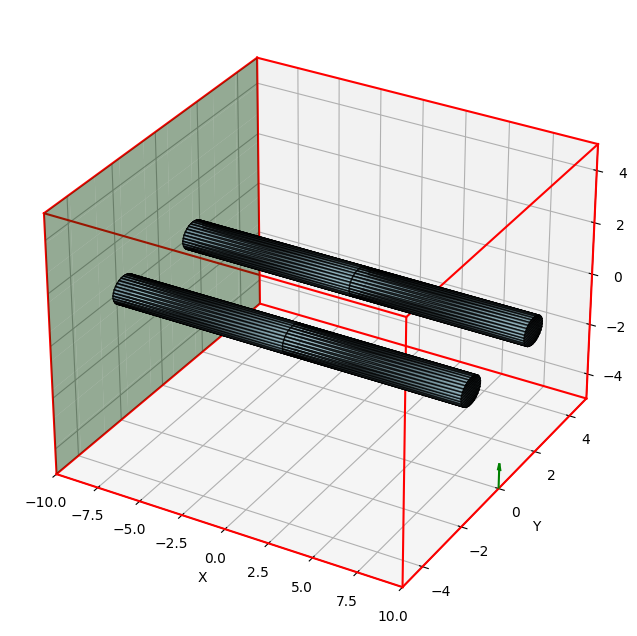

In [85]:
def plot_mesh(mesh: dict, save_path: str | None = None) -> None:
    """Plot a 3D triangular mesh with boundary conditions visualization.

    Args:
        mesh: Dictionary containing 'points' and 'faces' arrays.
        save_path: Optional path to save the plot as an image file.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(
        mesh["points"][:, 0],
        mesh["points"][:, 1],
        mesh["points"][:, 2],
        triangles=mesh["faces"],
        alpha=0.7,
        antialiased=True,
        color="lightblue",
        edgecolor="black",
    )

    # same as above in loop
    for x in [-Lx / 2, Lx / 2]:
        for y in [-Ly / 2, Ly / 2]:
            ax.plot(
                [x, x],
                [y, y],
                [-Lz / 2, Lz / 2],
                color="red",
            )
    for x in [-Lx / 2, Lx / 2]:
        for z in [-Lz / 2, Lz / 2]:
            ax.plot(
                [x, x],
                [-Ly / 2, Ly / 2],
                [z, z],
                color="red",
            )
    for y in [-Ly / 2, Ly / 2]:
        for z in [-Lz / 2, Lz / 2]:
            ax.plot(
                [-Lx / 2, Lx / 2],
                [y, y],
                [z, z],
                color="red",
            )

    # plane on x=0 to visualize dirichlet boundary
    yy, zz = jnp.meshgrid(
        jnp.linspace(-Ly / 2, Ly / 2, 10), jnp.linspace(-Ly / 2, Ly / 2, 10)
    )
    xx = -jnp.ones_like(yy) * Lx / 2
    ax.plot_surface(xx, yy, zz, alpha=0.4, color="green")

    ax.set_xlim(-Lx / 2, Lx / 2)
    ax.set_ylim(-Ly / 2, Ly / 2)
    ax.set_zlim(-Lz / 2, Lz / 2)

    # x axis label
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # green arrow on bottom right to indicate force direction
    ax.quiver(
        Lx / 2,
        0,
        -Lz / 2,
        0,
        0,
        1,
        length=1.0,
        color="green",
        arrow_length_ratio=0.3,
    )

    if save_path:
        # avoid showing the plot in notebook
        plt.savefig(save_path)
        plt.close(fig)


plot_mesh(mesh)

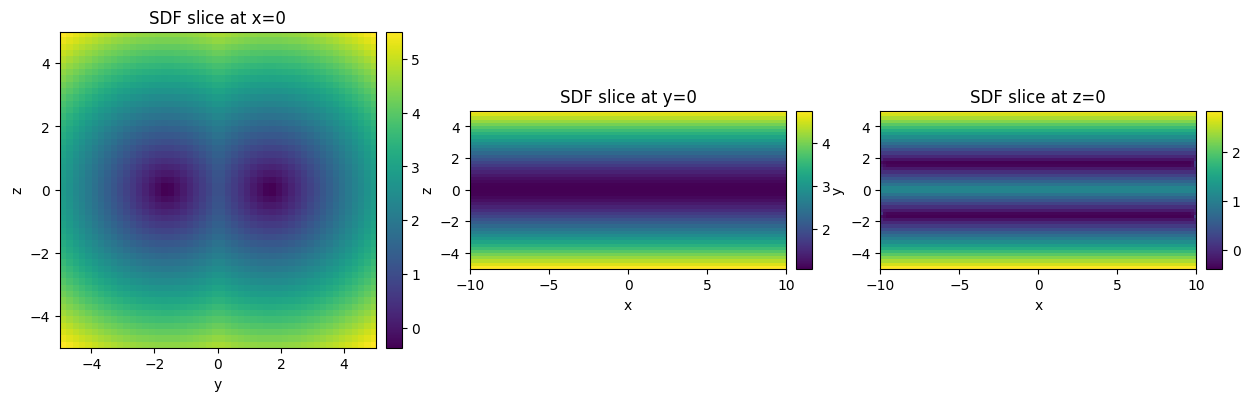

In [86]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_grid_slice(field_slice, extent, ax, title, xlabel, ylabel):
    im = ax.imshow(field_slice.T, extent=extent, origin="lower")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, orientation="vertical")
    return im


def plot_grid(field, Lx, Ly, Lz, Nx, Ny, Nz):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_grid_slice(
        field[Nx // 2, :, :],
        extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2),
        ax=axs[0],
        title="SDF slice at x=0",
        xlabel="y",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, Ny // 2, :],
        extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
        ax=axs[1],
        title="SDF slice at y=0",
        xlabel="x",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, :, Nz // 2],
        extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
        ax=axs[2],
        title="SDF slice at z=0",
        xlabel="x",
        ylabel="y",
    )


plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

Lets test the gradient of the design Tesseract

In [87]:
primal, vjp_fun = jax.vjp(
    lambda params: apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params.flatten(),
            "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
            "static_parameters": [n_chains, n_edges_per_chain + 1],
            "string_parameters": [],
            "mesh_tesseract": TesseractReference(bar_3d_tess),
            "grid_size": [Lx, Ly, Lz],
            "grid_elements": [Nx, Ny, Nz],
            "epsilon": 1e-3,  # epsilon, only used for FD of the jacobian
        },
    )["sdf"],
    initial_params,
)

grad = vjp_fun(jax.numpy.ones((Nx, Ny, Nz), dtype=jax.numpy.float32))[0]

print("Gradient shape:", grad.shape)

Gradient shape: (2, 3, 3)


And figure out an approate epsilon for finite difference based Jacobian computation.

In [88]:
# Lets figure out a good epsilon value for FD jacobian computation
epsilons = jnp.logspace(-6, 0, 6)
mean_grads = []
std_grads = []

for i in range(len(epsilons)):
    eps = epsilons[i]
    primal, vjp_fun = jax.vjp(
        lambda params, eps=eps: apply_tesseract(
            design_tess,
            {
                "differentiable_parameters": params.flatten(),
                "non_differentiable_parameters": jnp.array(
                    [bar_radius], dtype=jnp.float32
                ),
                "static_parameters": [n_chains, n_edges_per_chain + 1],
                "string_parameters": [],
                "mesh_tesseract": TesseractReference(bar_3d_tess),
                "grid_size": [Lx, Ly, Lz],
                "grid_elements": [Nx, Ny, Nz],
                "epsilon": eps.item(),  # epsilon, only used for FD of the jacobian
            },
        )["sdf"],
        initial_params,
    )

    grad = vjp_fun(jnp.ones((Nx, Ny, Nz), dtype=jnp.float32))[0]

    mean_grads.append(jnp.mean(jnp.abs(grad)))
    std_grads.append(jnp.std(grad))

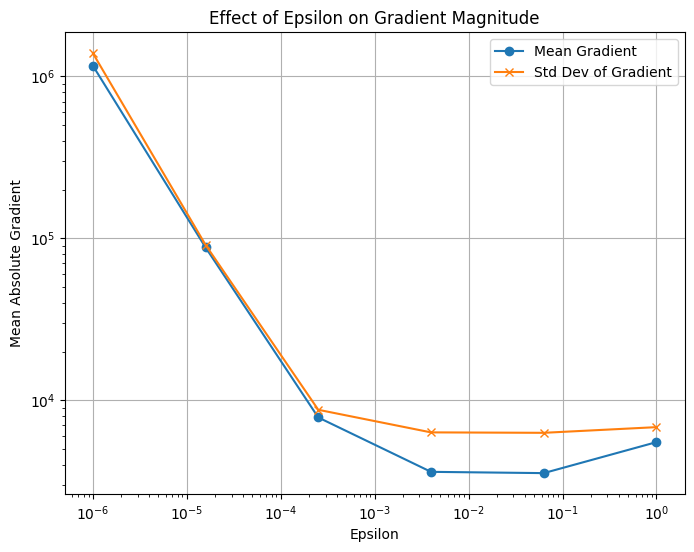

In [89]:
plt.figure(figsize=(8, 6))
plt.plot(epsilons, mean_grads, marker="o")
plt.plot(epsilons, std_grads, marker="x")
plt.xlabel("Epsilon")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Mean Absolute Gradient")
plt.title("Effect of Epsilon on Gradient Magnitude")
plt.grid(True)
plt.legend(["Mean Gradient", "Std Dev of Gradient"])

## Density and Sizing Field

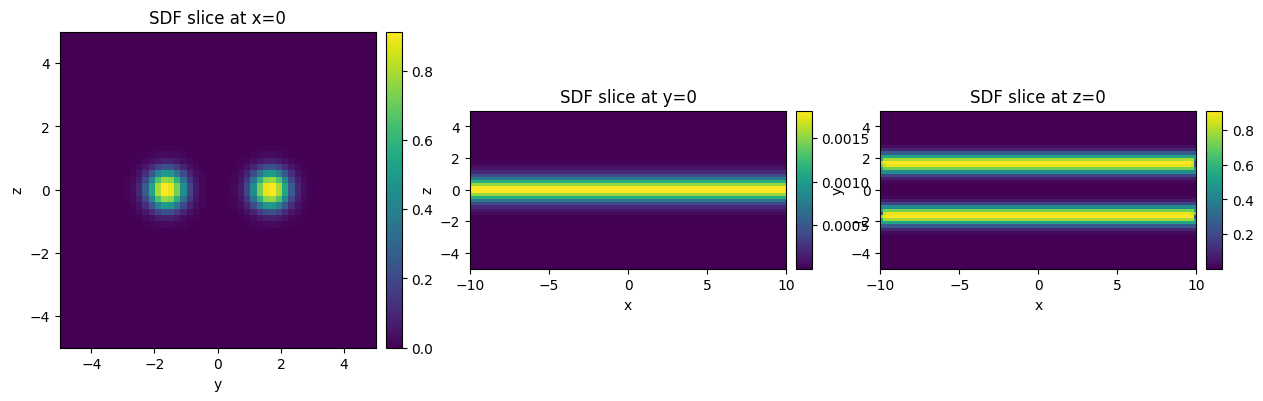

In [90]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 6.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho = sdf_to_rho(sdf)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz)

Sizing field min: 0.3333333432674408, max: 5.0


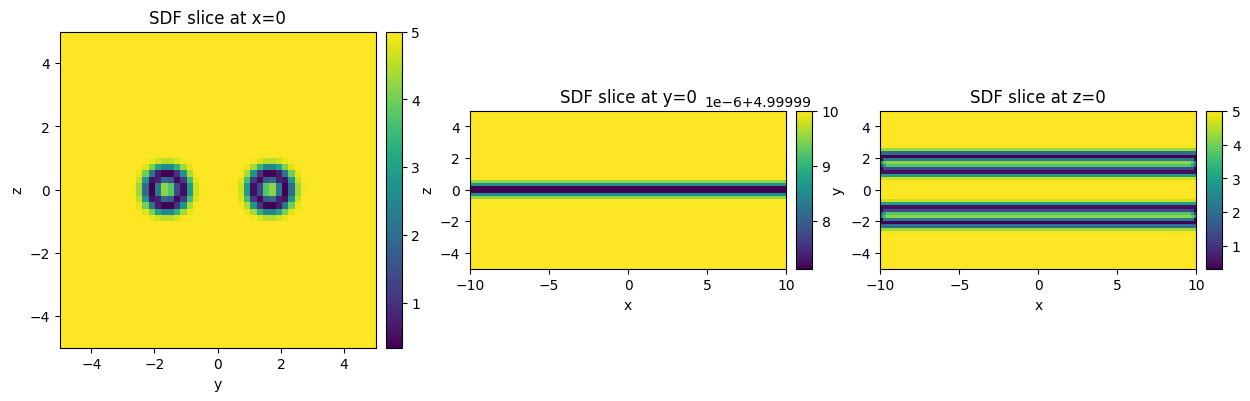

In [91]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 10.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing = sizing_field(sdf, min_size=Lx / 60, max_size=Lx / 4, scale=5.0)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

## Adpative Hex Meshing Tesseract

In [92]:
mesher = Tesseract.from_tesseract_api("meshing_tess/tesseract_api.py")

mesher_out = apply_tesseract(
    mesher,
    {
        "Lx": Lx,
        "Ly": Ly,
        "Lz": Lz,
        "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
        "field_values": rho,
        "max_subdivision_levels": 4,
        "max_points": 10000,
        "max_cells": 10000,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

adaptive_mesh = mesher_out["mesh"]

Mesh points: 773, Mesh faces: 435


Lets examine the produced mesh by exporting it to a VTK file and visualizing it in Paraview.

In [78]:
# Lets export it to a .vtk using pyvista
import pyvista as pv


def hex_to_pyvista(pts: np.ndarray, faces: np.ndarray) -> pv.UnstructuredGrid:
    """Convert hex mesh defined by points and faces into a PyVista UnstructuredGrid.

    Args:
        pts: Array of point coordinates, shape (N, 3).
        faces: Array of hexahedral cell connectivity, shape (M, 8).

    Returns:
        PyVista mesh representing the hexahedral grid.
    """
    # Define the cell type for hexahedrons (VTK_HEXAHEDRON = 12)
    cell_type = pv.CellType.HEXAHEDRON
    cell_types = np.array([cell_type] * faces.shape[0], dtype=np.uint8)

    # Prepare the cells array: [number_of_points, i0, i1, i2, i3, i4, i5, i6, i7]
    n_cells = faces.shape[0]
    cells = np.empty((n_cells, 9), dtype=np.int64)
    cells[:, 0] = 8  # Each cell has 8 points
    cells[:, 1:9] = faces

    # Flatten the cells array for PyVista
    cells = cells.flatten()

    return pv.UnstructuredGrid(cells, cell_types, pts)


# convert arrays to numpy
pts_np = np.array(adaptive_mesh["points"])
cells_np = np.array(adaptive_mesh["faces"])

hex_mesh = hex_to_pyvista(pts_np, cells_np)

print(hex_mesh)

hex_mesh.save("fem_shapeopt_mesh.vtk")

UnstructuredGrid (0x7c2dc47abd00)
  N Cells:    10000
  N Points:   10000
  X Bounds:   -1.000e+01, 1.000e+01
  Y Bounds:   -5.000e+00, 5.000e+00
  Z Bounds:   -5.000e+00, 5.000e+00
  N Arrays:   0


## Boundary Conditions

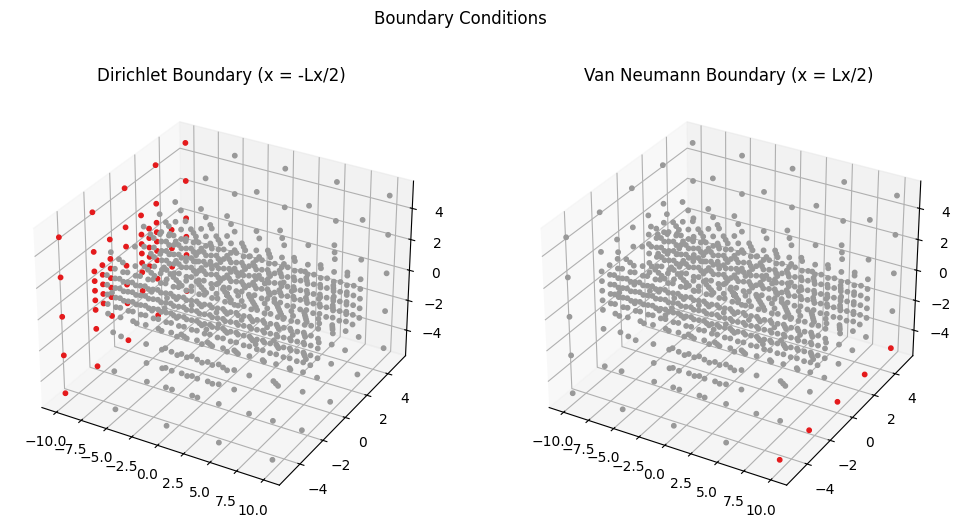

In [93]:
# Lets setup the boundary conditions

pts = adaptive_mesh["points"]

dirichlet_mask = pts[:, 0] <= -Lx / 2 + 1e-5
van_neumann_mask = jnp.logical_and(
    jnp.isclose(pts[:, 0], Lx / 2, atol=0.1),
    jnp.isclose(pts[:, 2], -Lz / 2, atol=0.1),
)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
colors = jnp.where(dirichlet_mask, 0.1, 0.2)

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=colors,
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask, 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

In [96]:
# fem_tess = Tesseract.from_image("structure-jax-fem")
# fem_tess.serve()
fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

In [97]:
compliance = apply_tesseract(
    fem_tess,
    {
        "rho": jnp.ones(adaptive_mesh["n_faces"]).reshape(-1, 1) * 0.5,
        "hex_mesh": adaptive_mesh,
        "dirichlet_mask": dirichlet_mask,
        "dirichlet_values": jnp.array([0.0]),
        "van_neumann_mask": van_neumann_mask,
        "van_neumann_values": jnp.array([[0.0, 0.0, 10.0]]),
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

[11-06 11:59:00][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-06 11:59:00][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-06 11:59:00][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-06 11:59:00][DEBUG] jax_fem: Done pre-computations, took 0.0867314338684082 [s]
[11-06 11:59:00][INFO] jax_fem: Solving a problem with 435 cells, 773x3 = 2319 dofs.
[11-06 11:59:00][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.


[11-06 11:59:00][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-06 11:59:00][DEBUG] jax_fem: Start timing
[11-06 11:59:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 11:59:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.3051 seconds
[11-06 11:59:00][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 11:59:00][DEBUG] jax_fem: Before, l_2 res = 8365.442088610178, relative l_2 res = 1.0
[11-06 11:59:00][DEBUG] jax_fem: Solving linear system...
[11-06 11:59:00][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-06 11:59:00][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.1505362733491197e-11
[11-06 11:59:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-06 11:59:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.0129 seconds
[11-06 11:59:01][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-06 11:59:01][DEBUG] jax_fem: l_2 res = 1.54878

Compliance: 4628.8926
